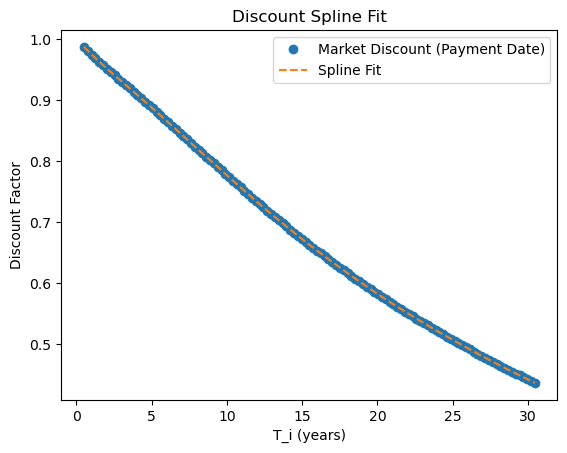

`xtol` termination condition is satisfied.
Number of iterations: 27, function evaluations: 108, CG iterations: 51, optimality: 2.46e+05, constraint violation: 0.00e+00, execution time: 0.89 s.
=== Calibration Results ===
Optimal [r0, a, sigma]: [0.02543754 0.00477074 0.00638713]
Success: True
Message: `xtol` termination condition is satisfied.
Objective (SSE): 76173594.27612159


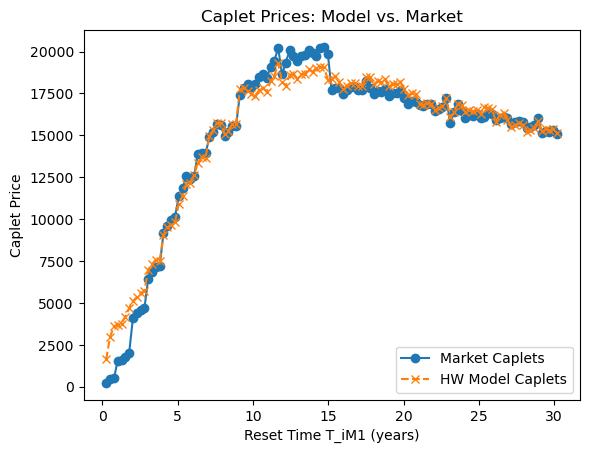

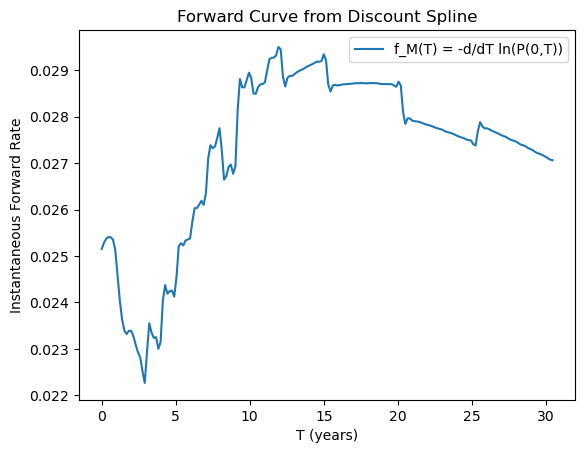

Maturity=0.50: Closed-Form=0.987361, Monte Carlo=0.987246
Maturity=2.08: Closed-Form=0.950429, Monte Carlo=0.949812
Maturity=3.65: Closed-Form=0.916583, Monte Carlo=0.916155
Maturity=5.23: Closed-Form=0.882523, Monte Carlo=0.882115
Maturity=6.81: Closed-Form=0.847549, Monte Carlo=0.844836
Maturity=8.38: Closed-Form=0.812145, Monte Carlo=0.811136
Maturity=9.96: Closed-Form=0.777295, Monte Carlo=0.774856
Maturity=11.53: Closed-Form=0.742785, Monte Carlo=0.740648
Maturity=13.11: Closed-Form=0.709530, Monte Carlo=0.704730
Maturity=14.69: Closed-Form=0.677741, Monte Carlo=0.665614
Maturity=16.26: Closed-Form=0.647601, Monte Carlo=0.641490
Maturity=17.84: Closed-Form=0.618943, Monte Carlo=0.610701
Maturity=19.42: Closed-Form=0.591553, Monte Carlo=0.587575
Maturity=20.99: Closed-Form=0.565691, Monte Carlo=0.564124
Maturity=22.57: Closed-Form=0.541398, Monte Carlo=0.544359
Maturity=24.14: Closed-Form=0.518291, Monte Carlo=0.516643
Maturity=25.72: Closed-Form=0.496255, Monte Carlo=0.491419
Matu

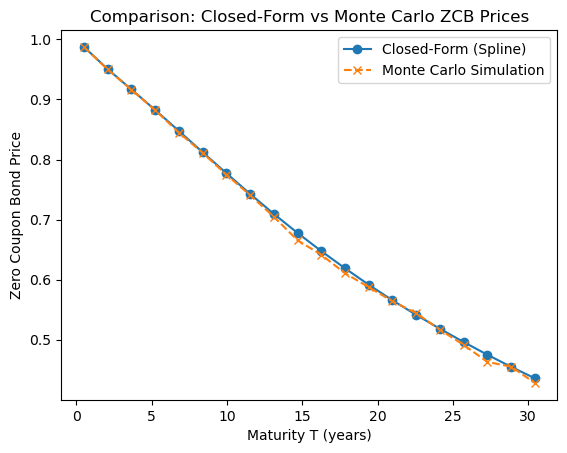

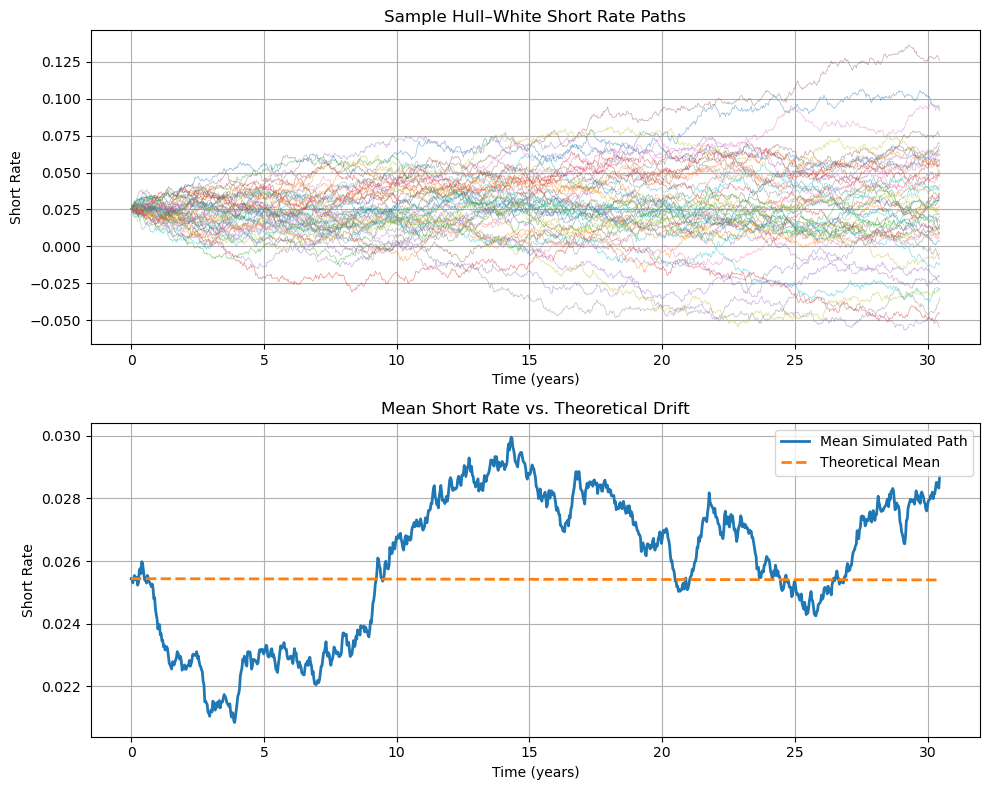

[DONE]


In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.interpolate import CubicSpline
from scipy.optimize import minimize
import warnings

warnings.filterwarnings('ignore')

############################
# PART ONE: Calibration
############################

def build_discount_spline(excel_file='capdata.xlsx'):
    """
    Reads market data from 'capdata.xlsx' assuming at least columns:
       'T_i'      : time in years to the *payment* date
       'Discount' : discount factor P(0, T_i)
    Builds a cubic spline of ln(P(0,T)) vs. T.
    Returns:
       - cs : CubicSpline object for ln(P(0,T))
       - df : the original DataFrame (sorted by T_i)
    """
    df = pd.read_excel(excel_file)
    df.sort_values('T_i', inplace=True)
    T_array = df['T_i'].values
    P_array = df['Discount'].values  # P(0,T_i)

    lnP_array = np.log(P_array)
    cs = CubicSpline(T_array, lnP_array, bc_type='natural')
    return cs, df

def discount_spline(cs, T):
    """Given a spline cs of ln(P(0,T)), return discount factor P(0,T)."""
    return np.exp(cs(T))

def forward_spline(cs, T):
    """Instantaneous forward rate: f_M(T) = -d/dT ln(P(0,T))."""
    return -cs.derivative()(T)

def caplet_HullWhite(strike, notional, tau, T_reset, P_T, P_S, a, sigma):
    """
    Price a single caplet under Hull–White with reset at T_reset and payment at T_reset + tau.
    
    strike : decimal (annualized strike as a decimal)
    notional : float (notional amount)
    tau : accrual factor
    T_reset : time to accrual start
    P_T : discount factor P(0, T_reset)
    P_S : discount factor P(0, T_reset+tau)
    a, sigma : HW model parameters
    """
    X_new = 1.0 / (1.0 + strike * tau)
    N_new = notional * (1.0 + strike * tau)
    B = (1.0 - np.exp(-a * tau)) / a
    sigma_p = sigma * np.sqrt((1.0 - np.exp(-2.0 * a * T_reset)) / (2.0 * a)) * B
    h = (1.0 / sigma_p) * np.log((P_S / P_T) / X_new) + (sigma_p / 2.0)
    price = N_new * (X_new * P_T * stats.norm.cdf(-h + sigma_p) - P_S * stats.norm.cdf(-h))
    return price

def price_caplets_HW(r0, a, sigma,
                     T_reset_array, tau_array, strike_array, notional_array,
                     discount_cs):
    """
    Prices caplets using the HW model.
    Each caplet j has:
      - Reset time T_reset_array[j]
      - Payment time T_reset_array[j] + tau_array[j]
    """
    n = len(T_reset_array)
    results = np.zeros(n)
    for j in range(n):
        T_reset_j = T_reset_array[j]
        tau_j = tau_array[j]
        strike_j = strike_array[j]
        N_j = notional_array[j]
        P_T = discount_spline(discount_cs, T_reset_j)
        P_S = discount_spline(discount_cs, T_reset_j + tau_j)
        results[j] = caplet_HullWhite(strike_j, N_j, tau_j, T_reset_j, P_T, P_S, a, sigma)
    return results

def objective_hw(x, market_caplet_prices,
                 T_reset_array, tau_array, strike_array, notional_array,
                 discount_cs,
                 objective_type='caplet'):
    """
    Objective function for calibration: sum of squared errors between market and model caplet prices.
    x = [r0, a, sigma]
    """
    r0, a, sigma = x
    model_prices = price_caplets_HW(r0, a, sigma,
                                    T_reset_array, tau_array, strike_array, notional_array,
                                    discount_cs)
    if objective_type == 'cap':
        sum_model = np.cumsum(model_prices)
        sum_market = np.cumsum(market_caplet_prices)
        mse = np.sum((sum_model - sum_market)**2)
    else:
        mse = np.sum((model_prices - market_caplet_prices)**2)
    return mse

############################
# PART TWO: Simulation Functions
############################

def get_fM_list(cs, t, T, N):
    """
    Generate a list of estimated instantaneous forward rates along a grid from t to T.
    Instead of using an external market_rate, we use the discount spline.
    """
    dt = (T - t) / N
    times = [t + dt * (j+1) for j in range(N)]
    return [forward_spline(cs, time) for time in times]

def simulate_ZCB_price(a, sigma, t, T, rt, cs, M=2000, N=1000):
    """
    Monte Carlo simulation to estimate zero-coupon bond price P(t,T) under the HW model.
    We simulate paths for the short rate r over [t, T] and compute exp(-integral(r dt)).
    
    Parameters:
      a, sigma : HW parameters
      t, T : start and maturity times
      rt : initial short rate (r(t))
      cs: discount spline (used for the forward rate term)
      M : number of Monte Carlo paths
      N : time subdivisions per path
    Returns:
      Estimated bond price.
    """
    dt = (T - t) / N
    # Get estimated forward rates on the grid from t to T.
    fM_list = get_fM_list(cs, t, T, N)
    
    bond_prices = np.zeros(M)
    for i in range(M):
        r = rt
        # Use the forward rate at time t (with no correction at t)
        alpha_prev = forward_spline(cs, t)  # plus correction term that is zero at dt=0
        integral = 0.0
        for j in range(N):
            time_next = t + dt * (j + 1)
            # Compute instantaneous forward rate at the new time plus the correction term;
            # note: in the original code, correction was sigma**2/(2*a**2)*(1-np.exp(-a*(time)))**2
            alpha_current = forward_spline(cs, time_next) + sigma**2/(2*a**2) * (1 - np.exp(-a * time_next))**2
            r = r * np.exp(-a*dt) + (alpha_current - alpha_prev * np.exp(-a*dt)) + sigma * np.exp(-a*dt) * np.random.normal(0, np.sqrt(dt))
            alpha_prev = alpha_current
            integral += dt * r
        bond_prices[i] = np.exp(-integral)
    return np.mean(bond_prices)

def simulate_short_rate_paths(a, sigma, t, T, rt, cs, M=50, N=1000):
    """
    Simulate M paths of the HW short rate from time t to T.
    Returns a list of arrays (each with N+1 points) and the corresponding time grid.
    """
    dt = (T - t) / N
    time_grid = np.linspace(t, T, N+1)
    paths = []
    for i in range(M):
        path = [rt]
        r = rt
        alpha_prev = forward_spline(cs, t)
        for j in range(N):
            time_next = t + dt * (j + 1)
            alpha_current = forward_spline(cs, time_next)
            r = r * np.exp(-a*dt) + (alpha_current - alpha_prev * np.exp(-a*dt)) + sigma * np.exp(-a*dt) * np.random.normal(0, np.sqrt(dt))
            alpha_prev = alpha_current
            path.append(r)
        paths.append(np.array(path))
    return time_grid, paths

############################
# MAIN SCRIPT
############################

if __name__ == "__main__":
    # ------------------------------
    # PART ONE: Calibration
    # ------------------------------
    # Build discount spline from capdata.xlsx
    discount_cs, capdata = build_discount_spline("./Downloads/capdata.xlsx")
    
    # Quick check of spline fit vs. market data
    T_i_array = capdata['T_i'].values
    P_i_array = capdata['Discount'].values
    P_fit = discount_spline(discount_cs, T_i_array)
    
    plt.figure()
    plt.plot(T_i_array, P_i_array, 'o', label='Market Discount (Payment Date)')
    plt.plot(T_i_array, P_fit, '--', label='Spline Fit')
    plt.xlabel("T_i (years)")
    plt.ylabel("Discount Factor")
    plt.title("Discount Spline Fit")
    plt.legend()
    plt.show()
    
    # Extract caplet data from file (adjust column names as needed)
    T_reset_array = capdata['T_iM1'].values      # reset times in years
    tau_array     = capdata['tau_i'].values        # accrual fractions
    strike_array  = capdata['CapStrike'].values / 100  # convert to decimal
    notional_array = capdata['Notional'].values
    market_caplet_prices = capdata['PV'].values
    
    # Initial guess for [r0, a, sigma]
    idx_min = np.argmin(T_i_array)
    T_min   = T_i_array[idx_min]
    P_min   = P_i_array[idx_min]
    r0_init = -np.log(P_min)/T_min
    a_init = 0.1
    sigma_init = 0.01
    x0 = [r0_init, a_init, sigma_init]
    
    # Calibrate using scipy.optimize.minimize
    args = (market_caplet_prices,
            T_reset_array,
            tau_array,
            strike_array,
            notional_array,
            discount_cs,
            'caplet')
    
    res = minimize(objective_hw,
                   x0,
                   args=args,
                   method='trust-constr',
                   options={'disp': True})
    
    print("=== Calibration Results ===")
    print("Optimal [r0, a, sigma]:", res.x)
    print("Success:", res.success)
    print("Message:", res.message)
    print("Objective (SSE):", res.fun)
    
    # Compare model vs market caplet prices
    r0_opt, a_opt, sigma_opt = res.x
    model_prices = price_caplets_HW(r0_opt, a_opt, sigma_opt,
                                    T_reset_array, tau_array, strike_array, notional_array,
                                    discount_cs)
    
    plt.figure()
    plt.plot(T_reset_array, market_caplet_prices, 'o-', label='Market Caplets')
    plt.plot(T_reset_array, model_prices, 'x--', label='HW Model Caplets')
    plt.xlabel("Reset Time T_iM1 (years)")
    plt.ylabel("Caplet Price")
    plt.title("Caplet Prices: Model vs. Market")
    plt.legend()
    plt.show()
    
    # Plot the instantaneous forward rate derived from the discount spline
    T_grid = np.linspace(0, max(T_i_array), 200)
    f_grid = forward_spline(discount_cs, T_grid)
    plt.figure()
    plt.plot(T_grid, f_grid, label='f_M(T) = -d/dT ln(P(0,T))')
    plt.xlabel("T (years)")
    plt.ylabel("Instantaneous Forward Rate")
    plt.title("Forward Curve from Discount Spline")
    plt.legend()
    plt.show()
    
    # ------------------------------
    # PART TWO: Simulation & Comparison
    # ------------------------------
    # For comparison, we generate a range of maturities.
    # The closed-form ZCB prices are simply given by the discount spline.
    maturities = np.linspace(0.5, max(T_i_array), 20)  # for example, 20 maturities from 0.5 to max T_i
    closed_form_prices = []
    mc_prices = []
    
    # Use the calibrated initial short rate r0_opt as r(t) at t=0.
    rt = r0_opt  
    for T_val in maturities:
        cf_price = discount_spline(discount_cs, T_val)
        mc_price = simulate_ZCB_price(a_opt, sigma_opt, t=0, T=T_val, rt=rt, cs=discount_cs, M=2000, N=1000)
        closed_form_prices.append(cf_price)
        mc_prices.append(mc_price)
        print(f"Maturity={T_val:.2f}: Closed-Form={cf_price:.6f}, Monte Carlo={mc_price:.6f}")
    
    # Plot the comparison line chart: Zero Coupon Bond Prices vs. Maturity
plt.figure()
plt.plot(maturities, closed_form_prices, 'o-', label='Closed-Form (Spline)')
plt.plot(maturities, mc_prices, 'x--', label='Monte Carlo Simulation')
plt.xlabel("Maturity T (years)")
plt.ylabel("Zero Coupon Bond Price")
plt.title("Comparison: Closed-Form vs Monte Carlo ZCB Prices")
plt.legend()
plt.show()
    
# ============================================================================
# Two‑panel plot: (1) sample HW short‐rate paths & (2) mean vs. theoretical drift
# ============================================================================
r0_opt, a_opt, sigma_opt = res.x  # from your calibration
# re‑simulate (or reuse) the same M paths you used before
time_grid, paths = simulate_short_rate_paths(
    a_opt, sigma_opt,
    t=0, T=max(capdata['T_i']), rt=r0_opt,
    cs=discount_cs, M=50, N=1000
)

plt.figure(figsize=(10, 8))

# --- Panel 1: individual sample paths ---
plt.subplot(2, 1, 1)
for path in paths:
    plt.plot(time_grid, path, linewidth=0.5, alpha=0.5)
plt.title("Sample Hull–White Short Rate Paths")
plt.xlabel("Time (years)")
plt.ylabel("Short Rate")
plt.grid(True)

# --- Panel 2: mean simulated path vs. theoretical mean ---
plt.subplot(2, 1, 2)
# compute mean of simulations
mean_sim = np.mean(np.stack(paths), axis=0)
plt.plot(time_grid, mean_sim, label="Mean Simulated Path", linewidth=2)

# theoretical instantaneous mean: r0·e^(−a·t) + f(0)·[1−e^(−a·t)]
f0 = forward_spline(discount_cs, 0.0)
theoretical_mean = r0_opt * np.exp(-a_opt * time_grid) \
                   + f0 * (1 - np.exp(-a_opt * time_grid))
plt.plot(time_grid, theoretical_mean, '--', label="Theoretical Mean", linewidth=2)

plt.title("Mean Short Rate vs. Theoretical Drift")
plt.xlabel("Time (years)")
plt.ylabel("Short Rate")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

print("[DONE]")